In [1]:
from lbmpy.session import *
from lbmpy.phasefield.analytical import *
from lbmpy.phasefield.n_phase_boyer import *
from lbmpy.phasefield.kerneleqs import *

from pystencils.fd.spatial import discretize_spatial
from pystencils.simp import sympy_cse_on_assignment_list
from lbmpy.phasefield.cahn_hilliard_lbm import *
from pystencils.fd.derivation import *

one = sp.sympify(1)

# Chemical potential

Current state:

- not stable (yet)
- without LB coupling the model is stable

In [2]:
domain_size = (100, 100)

n = 4
c = sp.symbols(f"c_:{n}")
simple_potential = False
omega_h = 1.3

if simple_potential:
    f = free_energy_functional_n_phases_penalty_term(c, interface_width=1, kappa=(0.05, 0.05/2, 0.05/4))
else:
    ε = one * 4
    mobility = one * 2 / 1000
    κ = (one,  one/2, one/3, one/4)
    sigma_factor = one / 15
    σ = sp.ImmutableDenseMatrix(n, n, lambda i,j: sigma_factor* (κ[i] + κ[j]) if i != j else 0 )
    
    α, _ = diffusion_coefficients(σ)
    f_b, f_if, mu_b, mu_if = chemical_potential_n_phase_boyer(c, ε, σ, one, 
                                                              assume_nonnegative=True, zero_threshold=1e-10)

# Data Setup

In [3]:
dh = create_data_handling(domain_size, periodicity=True, default_ghost_layers=2)
p_linearization = symmetric_tensor_linearization(dh.dim)

c_field = dh.add_array("c", values_per_cell=n)
rho_field = dh.add_array("rho")
mu_field = dh.add_array("mu", values_per_cell=n, latex_name="\\mu")
pressure_field = dh.add_array("P", values_per_cell=len(p_linearization))
force_field = dh.add_array("F", values_per_cell=dh.dim)
u_field = dh.add_array("u", values_per_cell=dh.dim)

# Distribution functions for each order parameter
pdf_field = []
pdf_dst_field = []
for i in range(n):
    pdf_field_local = dh.add_array("f%d" % i, values_per_cell=9) # 9 for D2Q9
    pdf_dst_field_local = dh.add_array("f%d_dst"%i, values_per_cell=9, latex_name="f%d_{dst}" % i)
    pdf_field.append(pdf_field_local)
    pdf_dst_field.append(pdf_dst_field_local)

# Distribution functions for the hydrodynamics
pdf_hydro_field = dh.add_array("fh", values_per_cell=9)
pdf_hydro_dst_field = dh.add_array("fh_dst", values_per_cell=9, latex_name="fh_{dst}")

### μ-Kernel

In [4]:
if simple_potential:
    mu_assignments = mu_kernel(f, c, c_field, mu_field, discretization='isotropic')
else:
    mu_subs = {a: b for a, b in zip(c, c_field.center_vector)}
    mu_if_discrete = [discretize_spatial(e.subs(mu_subs), dx=1, stencil='isotropic') for e in mu_if]
    mu_b_discrete = [e.subs(mu_subs) for e in mu_b]

    mu_assignments = [Assignment(mu_field(i),
                                 mu_if_discrete[i] + mu_b_discrete[i]) for i in range(n)]

    mu_assignments = sympy_cse_on_assignment_list(mu_assignments)
    
μ_kernel = create_kernel(mu_assignments).compile()

In [5]:
second_neighbor_stencil = [(i, j) 
                           for i in (-2, -1, 0, 1, 2)
                           for j in (-2, -1, 0, 1, 2)
                          ]
x_diff = FiniteDifferenceStencilDerivation((0,), second_neighbor_stencil)
x_diff.set_weight((2, 0), sp.Rational(1, 10))
x_diff.assume_symmetric(0, anti_symmetric=True)
x_diff.assume_symmetric(1)
x_diff_stencil = x_diff.get_stencil(isotropic=True)

y_diff = FiniteDifferenceStencilDerivation((1,), second_neighbor_stencil)
y_diff.set_weight((0, 2), sp.Rational(1, 10))
y_diff.assume_symmetric(1, anti_symmetric=True)
y_diff.assume_symmetric(0)
y_diff_stencil = y_diff.get_stencil(isotropic=True)

In [6]:
μ = mu_field
μ_discretization = {}

for i in range(n):
    μ_discretization.update({Diff(μ(i), 0): x_diff_stencil.apply(μ(i)),
                             Diff(μ(i), 1): y_diff_stencil.apply(μ(i))})
force_rhs = force_from_phi_and_mu(order_parameters=c_field.center_vector, dim=dh.dim, mu=mu_field.center_vector)
force_rhs = force_rhs.subs(μ_discretization)
force_assignments = [Assignment(force_field(i), force_rhs[i]) for i in range(dh.dim)]

force_kernel = create_kernel(force_assignments).compile()

## Lattice Boltzmann kernels

For each order parameter a Cahn-Hilliard LB method computes the time evolution.

In [7]:
if simple_potential:
    mu_alpha = mu_field.center_vector
else:
    mu_alpha = mobility * α * mu_field.center_vector 

In [8]:
# Defining the Cahn-Hilliard Collision assignments
ch_kernels = []

for i in range(n):
    ch_method = cahn_hilliard_lb_method(get_stencil("D2Q9"), mu_alpha[i],
                                        relaxation_rate=1.0, gamma=1.0)
    kernel = create_lb_function(lb_method=ch_method, 
                                velocity_input=u_field.center_vector, 
                                compressible=True,
                                output={'density': c_field(i)},
                                optimization={"symbolic_field":pdf_field[i],
                                              "symbolic_temporary_field": pdf_dst_field[i]})
    
    ch_kernels.append(kernel)

In [9]:
hydro_lbm = create_lb_function(relaxation_rate=omega_h, force=force_field, 
                               compressible=True,  
                               optimization={"symbolic_field": pdf_hydro_field,
                                             "symbolic_temporary_field": pdf_hydro_dst_field},
                               output={'velocity': u_field}
                               )
#hydro_lbm.update_rule

# Initialization

In [10]:
def set_c(slice_obj, values):
    for block in dh.iterate(slice_obj):
        arr = block[c_field.name]
        arr[..., : ] = values
        
def init():
    dh.fill(u_field.name, 0)
    dh.fill(mu_field.name, 0)
    dh.fill(force_field.name, 0)
    
    set_c(make_slice[:, :], [0, 0, 0, 0])
    set_c(make_slice[:, 0.5:], [1, 0, 0, 0])
    set_c(make_slice[:, :0.5], [0, 1, 0, 0])
    set_c(make_slice[0.3:0.7, 0.3:0.7], [0, 0, 1, 0])
    
pdf_sync_fns = dh.synchronization_function([f.name for f in pdf_field])  
hydro_sync_fn=dh.synchronization_function([pdf_hydro_field.name])
c_sync_fn = dh.synchronization_function([c_field.name])
mu_sync_fn = dh.synchronization_function([mu_field.name])

def time_loop(steps):
    for i in range(steps):
        c_sync_fn()
        dh.run_kernel(μ_kernel)

        mu_sync_fn()
        dh.run_kernel(force_kernel)

        hydro_sync_fn()
        dh.run_kernel(hydro_lbm)
        dh.swap(pdf_hydro_field.name, pdf_hydro_dst_field.name)

        pdf_sync_fns()
        for i in range(n):
            dh.run_kernel(ch_kernels[i])
            dh.swap(pdf_field[i].name,pdf_dst_field[i].name)

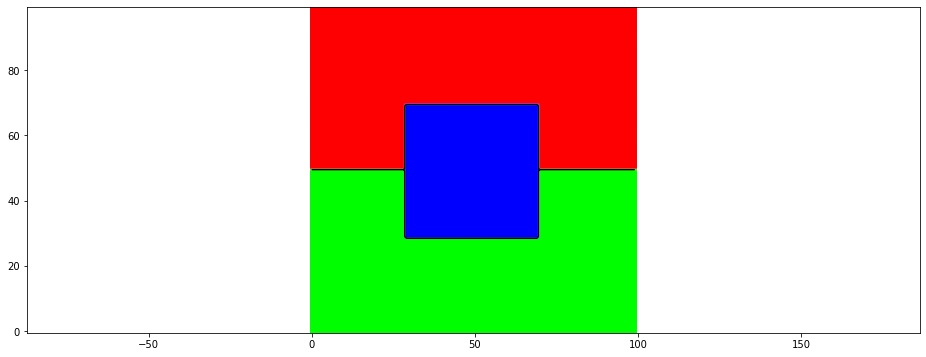

In [11]:
init()
plt.phase_plot(dh.gather_array(c_field.name))

In [12]:
time_loop(10)

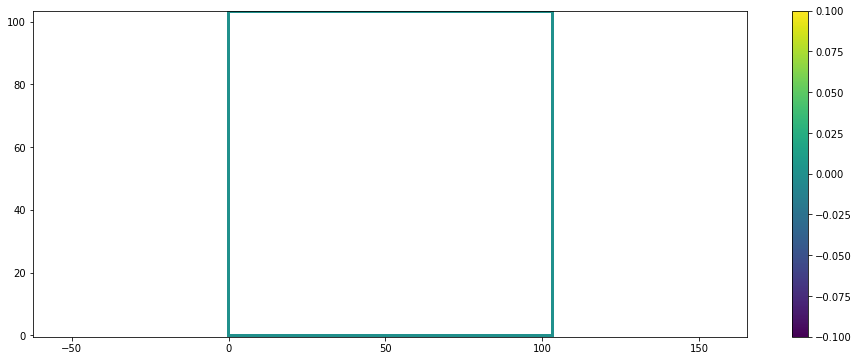

In [13]:
#plt.scalar_field(dh.cpu_arrays[mu_field.name][..., 0])
plt.scalar_field(dh.cpu_arrays[u_field.name][..., 0])
plt.colorbar();